### Acknowledgement
Name: Zuha Aqib     
ERP ID: 26106    
Section: 10am Miss Solat     
Date: (written on) 08-Mar-25    

code has been taken from Miss Solat's code files and written by Zuha themselves. 

In [896]:
from datetime import datetime
print("Last time code executed:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

Last time code executed: 2025-03-09 16:25:53


In [897]:
erp = 26106 
# will be referenced later on in the code when we use it for random_state
erp

26106

# Imports
here we import all the necessary libraries and modules

In [898]:
# to load the dataset
import warnings
warnings.filterwarnings('ignore')

# to make the file of wss, sil scores open immediately
import os

# to handle the data and perform numerical operations on it
import pandas as pd
import numpy as np

# to do natural language processing
import nltk

# preprocessing: to clean the data
import re

# preprocessing: stop words removal
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# preprocessing: words tokenization
from nltk.tokenize import word_tokenize

# preprocessing: stemmming and lemmatization
from nltk.stem import WordNetLemmatizer

# model running
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# clustering: k means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to plot the graph
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

# Time Displayer
this code is a function that we will call at multiple instances of the code to see how long it took to run the code to see when it ran

In [899]:
# Function to get current date and time as a string
def get_current_datetime():
    return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

# Load the Dataset
Here we load the dataset from a csv file and then save it into a variable

In [900]:
dummy_dataframe = pd.read_csv("dataset/news_Feb_14.csv")
dummy_dataframe = dummy_dataframe.iloc[:, 0]  # Select only the headline column
documents = dummy_dataframe.tolist()  # Convert to list
documents

['ECC endorses purchase of $582mn capital shares in BRICS’s New Development Bank',
 'Netanyahu’s statement to establish Palestinian state in Saudi Arabia irresponsible, provocative: FO',
 'India, US agree to resolve trade and tariff rows after Trump-Modi talks',
 'Aurangzeb discusses Pakistan’s structural reforms with IFC chief',
 'HBL, S&P Global launch Pakistan’s first manufacturing PMI',
 'KSE-100 closes 479 points lower as late-session selling erases intra-day gains',
 'PPL executes agreements for Sui Gas Field operations',
 'Hubco Green, PSO collaborate to setup EV charging infrastructure across Pakistan',
 'Rupee records marginal improvement against US dollar',
 'At least 9 dead, 7 injured in Balochistan’s Harnai blast',
 'Gold adds to record rally, reaches Rs306,200 per tola in Pakistan',
 'IMF’s 2024 Article IV report, and debate on inflation—I',
 'Pakistan CPI 2024 – deep-rooted corruption persists',
 '‘Like a wormhole’: Musk promises ‘Dubai Loop’ tunnel network',
 'Reforming 

In [901]:
original_headlines = documents.copy()

# Preprocessing
here we perform the preprocessing of data like:
- lowercase text
- stopword removal
- stemming or lemmatization
- n-grams

## Lowercase Conversion
here we convert our text to lowercase

In [902]:
documents = [document.lower() for document in documents]

print("Finished executing at:", get_current_datetime())
documents

Finished executing at: 2025-03-09 16:25:53


['ecc endorses purchase of $582mn capital shares in brics’s new development bank',
 'netanyahu’s statement to establish palestinian state in saudi arabia irresponsible, provocative: fo',
 'india, us agree to resolve trade and tariff rows after trump-modi talks',
 'aurangzeb discusses pakistan’s structural reforms with ifc chief',
 'hbl, s&p global launch pakistan’s first manufacturing pmi',
 'kse-100 closes 479 points lower as late-session selling erases intra-day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistan’s harnai blast',
 'gold adds to record rally, reaches rs306,200 per tola in pakistan',
 'imf’s 2024 article iv report, and debate on inflation—i',
 'pakistan cpi 2024 – deep-rooted corruption persists',
 '‘like a wormhole’: musk promises ‘dubai loop’ tunnel network',
 'reforming 

## Data Cleaning
here we clean the data

In [903]:
import re
import unicodedata

def clean_text(text):
    text = text.encode('ascii', 'ignore').decode()  # Remove non-ASCII characters
    text = unicodedata.normalize("NFKD", text)  # Normalize Unicode text
    
    # Separate numbers attached to words
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)  # number-word
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)  # word-number
    
    text = text.replace("-", " ") # replace hyphens with spaces to tokenize the numbers and words
    text = re.sub(r'[^\w\s,]', '', text)  # Remove everything except words, numbers, and commas
    text = re.sub(r'\s+', ' ', text).strip()   # remove extra spaces
    
    return text

In [904]:
documents = [clean_text(text) for text in documents]
documents

['ecc endorses purchase of 582 mn capital shares in bricss new development bank',
 'netanyahus statement to establish palestinian state in saudi arabia irresponsible, provocative fo',
 'india, us agree to resolve trade and tariff rows after trump modi talks',
 'aurangzeb discusses pakistans structural reforms with ifc chief',
 'hbl, sp global launch pakistans first manufacturing pmi',
 'kse 100 closes 479 points lower as late session selling erases intra day gains',
 'ppl executes agreements for sui gas field operations',
 'hubco green, pso collaborate to setup ev charging infrastructure across pakistan',
 'rupee records marginal improvement against us dollar',
 'at least 9 dead, 7 injured in balochistans harnai blast',
 'gold adds to record rally, reaches rs 306,200 per tola in pakistan',
 'imfs 2024 article iv report, and debate on inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like a wormhole musk promises dubai loop tunnel network',
 'reforming pension funds i

## Stop Words Removal
here we remove stop words. we have three options of:
- either declaring all possible stop words and then iteratively checking each word in the document if its a stop word and then adding the non-stop words. 
```
sw = ["from","of","and", "on","for", "the","have","a","be","to","in","will","if","by","into","as"]
docs_list = []
for d in document: 
    d_nlp = nlp(d.lower())
    t_list = []
    for token in d_nlp:
        tok_lem = str(token.lemma_)
        if (tok_lem not in sw):
            t_list.append(tok_lem)
    str_ = ' '.join(t_list) 
    docs_list.append(str_)
docs_list
```
However this is not a good practice. 
- pulling stop words from ```ntlk``` library: 
```
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
documents_no_stopwords = [" ".join([word for word in doc.split() if word not in stop_words]) 
```
However after running this code it didnt not remove stop words thus i removed it
- intializing stop_words in ```CountVectorizer()``` however here we are not using it
- using the ```ENGLISH_STOP_WORDS``` in ```sklearn```
```
tokens = [word for word in tokens if word not in stopwords.words('english') and word not in ENGLISH_STOP_WORDS]  
```
Lets try it and see it how it goes.

In [905]:
# Tokenize each document
tokenized_docs = [word_tokenize(doc) for doc in documents] 

# Remove stop words
filtered_docs = [[word for word in doc if word not in stopwords.words('english') and word not in ENGLISH_STOP_WORDS] for doc in tokenized_docs]

# Convert back to sentences if needed
documents = [" ".join(doc) for doc in filtered_docs]

documents

['ecc endorses purchase 582 mn capital shares bricss new development bank',
 'netanyahus statement establish palestinian state saudi arabia irresponsible , provocative fo',
 'india , agree resolve trade tariff rows trump modi talks',
 'aurangzeb discusses pakistans structural reforms ifc chief',
 'hbl , sp global launch pakistans manufacturing pmi',
 'kse 100 closes 479 points lower late session selling erases intra day gains',
 'ppl executes agreements sui gas field operations',
 'hubco green , pso collaborate setup ev charging infrastructure pakistan',
 'rupee records marginal improvement dollar',
 '9 dead , 7 injured balochistans harnai blast',
 'gold adds record rally , reaches rs 306,200 tola pakistan',
 'imfs 2024 article iv report , debate inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like wormhole musk promises dubai loop tunnel network',
 'reforming pension funds pakistan sustainable approach',
 'cjp afridi administers oath newly appointed sc judges',
 '

## Reduction
here we change words to a smaller common form instead of the 's. We do this using two ways:
- stemming
- lemmatization

here we perform lemmatization as in the previous assignment, lemmatization had worked much better

### Lemmatization
this also reduces words to their singular form and is said to be better as it only reduces to words in the dictionary. after our 48 trials in the previous assignment, lemmatization was much better.

In [906]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_doc(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

In [907]:
documents = [lemmatize_doc(doc) for doc in documents]
documents

['ecc endorses purchase 582 mn capital share bricss new development bank',
 'netanyahus statement establish palestinian state saudi arabia irresponsible , provocative fo',
 'india , agree resolve trade tariff row trump modi talk',
 'aurangzeb discusses pakistan structural reform ifc chief',
 'hbl , sp global launch pakistan manufacturing pmi',
 'kse 100 close 479 point lower late session selling erases intra day gain',
 'ppl executes agreement sui gas field operation',
 'hubco green , pso collaborate setup ev charging infrastructure pakistan',
 'rupee record marginal improvement dollar',
 '9 dead , 7 injured balochistans harnai blast',
 'gold add record rally , reach r 306,200 tola pakistan',
 'imf 2024 article iv report , debate inflationi',
 'pakistan cpi 2024 deep rooted corruption persists',
 'like wormhole musk promise dubai loop tunnel network',
 'reforming pension fund pakistan sustainable approach',
 'cjp afridi administers oath newly appointed sc judge',
 'solar panel import 8

## N-Grams
here we decide how we want the words to be tokenized, either they are
- unigram: singular
- bigram: pairs (doubular)

for this assignment, we will focus on unigrams.

In [908]:
# because we want unigrams, we DO NOT have to do anything and we will leave it the way it is

# Vectorization
here we convert the text to numerical format for the model to understand it. we have four ways to do it:
- word2Vec
- doc2vec

in this code we are exploring the first method

## Word2Vec
in word2vec we have two methods:
- cbow architecture (target is predicted by context)
- skipgram (target predicts context)

In [909]:
# for sg variable
# sg = 0 # CBOW
sg = 1 # Skip-Gram

if sg == 0:
    model_type = 'CBOW'
else:
    model_type = 'Skipgram'

print(f"sg={sg}, model={model_type}")

sg=1, model=Skipgram


### Variables to set
here we set variables like vector_size, window_size, count of epochs etc. we define them here so that in the code we dont have to change them. We can easily change them here and the code will change accordingly.

one thing to note here is that before starting the assignment i will make a list of each variable and what i want to test. then i will iterate over each variable keeping rest fixed, and write a loop to iterate over that variable and then i will select that as best. then for the next i will use its list but that previous one will be in its best. this will help me run as many things as i want in one code run.

In [910]:
vector_sizes = [50, 100, 150, 200, 250, 300]
# vector_sizes = [300, 325, 350, 400]
# vector_sizes = [400, 410, 425, 450, 500]
selected_vector_size = 400

In [911]:
windows = [3, 5, 7, 10, 12, 15, 20]
# windows = [8, 9, 10, 11, 12]
selected_window = windows[0]

In [912]:
epochs = [50, 100, 150, 200, 250]
# epochs = [5, 10, 20, 30, 40, 50, 60]
selected_epoch = epochs[0]

### Code declaration
here we declare our code using the following syntax

In [913]:
def get_avg_word2vec(tokens, model, vector_size=300):
    vectors = [model.wv[word] for word in tokens if word in model.wv]  
    return np.mean(vectors, axis=0) if vectors else np.zeros(vector_size) 

In [914]:
def run_word2vec (docs, vector_size, window_size, epoch):
    word2vec_model = Word2Vec(
        sentences=docs,                        # Tokenized text
        vector_size=vector_size,           # Each word is represented by a x-dimensional vector
        window=window_size,                     # Context window size
        min_count=1,                                # Ignores words that appear less than 'min_count' times
        workers=4,                                  # Number of CPU cores used
        sg=sg,                   
        epochs=epoch                       # Number of training iterations
    )
    # print(word2vec_model)
    
    # Convert the list to a Pandas Series
    documents_series = pd.Series(docs)

    docs = documents_series.apply(lambda x: get_avg_word2vec(x, word2vec_model))    
    docs = np.array(docs.tolist())
    
    # print(docs)
    
    return docs

# K Means Clustering
here we cluster the documents into similar categories using k means clustering algorithm. we will be testing the algorithm for three values of k: 5, 9 and 13

In [915]:
def display_k_means(k, data):
    print(f"Displaying {k} start time:", get_current_datetime())
    
    svd = TruncatedSVD(n_components=2, random_state=42)
    data = svd.fit_transform(data)
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    # Convert to DataFrame for visualization
    df_viz = pd.DataFrame({'X': data[:, 0], 'Y': data[:, 1], 'Cluster': labels})

    # Scatter plot of clusters
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_viz, x='X', y='Y', hue='Cluster', palette='tab10', s=100, edgecolor='black')
    plt.title("K-Means Clustering Visualization (2D Projection)")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(title="Cluster")
    plt.show()
    
    print("Finished displaying at:", get_current_datetime(), "\n")

In [916]:
def run_k_means(k, data, results, vector_size, window, epoch):
    print(f"Executing {k} start time:", get_current_datetime())
    
    kmeans = KMeans(n_clusters=k, random_state=erp)
    labels = kmeans.fit_predict(data)
    
    wss = kmeans.inertia_  # Within-Cluster Sum of Squares
    silhouette_avg = silhouette_score(data, labels)  # Silhouette Score
    
    print(f"K={k}: Silhouette Score and WSS={silhouette_avg:.4f}\t{wss:.4f}")
    
    results.append([k, f'Word2Vec', vector_size, window, epoch, model_type, silhouette_avg, wss])
    
    # Create a DataFrame to store headlines with their assigned clusters
    df_clusters = pd.DataFrame({'Headline': original_headlines, 'Cluster': labels})

    # Display sample headlines per cluster
    for cluster in range(k):
        print(f"\nCluster {cluster}:")
        sample_headlines = df_clusters[df_clusters["Cluster"] == cluster].sample(n=min(5, len(df_clusters[df_clusters["Cluster"] == cluster])), random_state=erp)
        for idx, row in sample_headlines.iterrows():
            print(f"- {row['Headline']}")
    
    display_k_means(k, data)
    
    print("Finished executing at:", get_current_datetime(), "\n")
    
    return silhouette_avg, wss

## Code Running
here we run the code in a for-loop, because we have many variables we need to test with k-means. thus we test them here.

In [917]:
copy_of_docs = documents

In [918]:
# window = selected_window
epoch = selected_epoch
vector_size = selected_vector_size
# the variable that is commented means that is the variable being tested

In [919]:
# define a output that will save each case WSS and silhoutee so that it can be saved into a csv file later on
results = []

In [920]:
# define an output that will save each WSS with its k so that we can plot a scree plot later on
wss_scores = []

In [921]:
# define a variable that will save the best combination for reference at the end
best_combination = []
best_WSS = 100000000000000000000000000 # we want lowest wss so we start with large value
best_Sil = 0    # we want max sil so we start with small value

In [922]:
def run_combinations(k, best_combination, best_Sil, best_WSS):
    sum_wss = 0
    count_wss = 0

    for window in windows:
        print("Executed at:", get_current_datetime(), "\n")
        documents = run_word2vec(copy_of_docs, vector_size, window, epoch)
        print(f"sg={sg}, Vector_Size={vector_size}, Window={window}, Epoch={epoch}")
        print("Finished displaying at:", get_current_datetime(), "\n")
        sil, wss = run_k_means(k, documents, results, vector_size, window, epoch)
        
        # sum the wss to find average for elbow plot
        sum_wss += wss
        count_wss += 1
        
        # compute max(sil, best_sil) and min(wss, best_wss) to find the BEST
        if sil > best_Sil and wss < best_WSS:
            best_combination = [k, "word", model_type, vector_size, window, epoch, sil, wss]
            best_WSS = wss
            best_Sil = sil
        else:
            # if best not found, pick if WSS is best however SIL is not best but it should be within 0.05 range
            sil_diff = best_Sil - sil
            wss_diff = best_WSS - wss
            if sil_diff >= 0 and sil_diff < 0.05 and wss_diff > 0:
                best_combination = [k, "word", model_type, vector_size, window, epoch, sil, wss]
                best_WSS = wss
                best_Sil = sil

    # once all combinations are tested, compute average and append that for elbow plots for that k
    avg_wss = sum_wss / count_wss
    wss_scores.append([k, avg_wss])
    
    return best_combination, best_Sil, best_WSS

2025-03-09 16:25:56,414 : INFO : collecting all words and their counts
2025-03-09 16:25:56,417 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:25:56,418 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:25:56,422 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:25:56,423 : INFO : Creating a fresh vocabulary
2025-03-09 16:25:56,425 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:25:56.425908', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:25:56,427 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Executed at: 2025-03-09 16:25:56 



2025-03-09 16:25:56,595 : INFO : EPOCH 5: training on 24723 raw words (4621 effective words) took 0.0s, 292270 effective words/s
2025-03-09 16:25:56,621 : INFO : EPOCH 6: training on 24723 raw words (4668 effective words) took 0.0s, 274800 effective words/s
2025-03-09 16:25:56,642 : INFO : EPOCH 7: training on 24723 raw words (4650 effective words) took 0.0s, 315329 effective words/s
2025-03-09 16:25:56,667 : INFO : EPOCH 8: training on 24723 raw words (4822 effective words) took 0.0s, 325468 effective words/s
2025-03-09 16:25:56,688 : INFO : EPOCH 9: training on 24723 raw words (4701 effective words) took 0.0s, 316223 effective words/s
2025-03-09 16:25:56,711 : INFO : EPOCH 10: training on 24723 raw words (4679 effective words) took 0.0s, 296252 effective words/s
2025-03-09 16:25:56,735 : INFO : EPOCH 11: training on 24723 raw words (4648 effective words) took 0.0s, 279914 effective words/s
2025-03-09 16:25:56,756 : INFO : EPOCH 12: training on 24723 raw words (4797 effective words) t

sg=1, Vector_Size=400, Window=3, Epoch=50
Finished displaying at: 2025-03-09 16:25:57 

Executing 5 start time: 2025-03-09 16:25:57
K=5: Silhouette Score and WSS=0.1084	2.1635

Cluster 0:
- Turkish President Erdogan receives guard of honour at PM House
- Pakistan’s greatest ODI chases: A look back after historic win over South Africa
- Senate Dy Chairman, Balochistan CM discuss development projects
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- JD Vance says US wields economic, military leverage on Russia in Ukraine talks

Cluster 1:
- Meta's new tools aim to protect users from Valentine's Day romance fraud
- CM Murad invites Japanese companies to invest in Karachi mass transit projects
- Non-banking microfinance sector: SECP announces series of initiatives to empower women, strengthen consumer protection
- The Ultimate Guide to Healing Foods: Eat Your Way to Better Health
- Pakistan keen to increase trade, investment with Japan: Governor

Cluster 2:
- Pakistan CPI 2

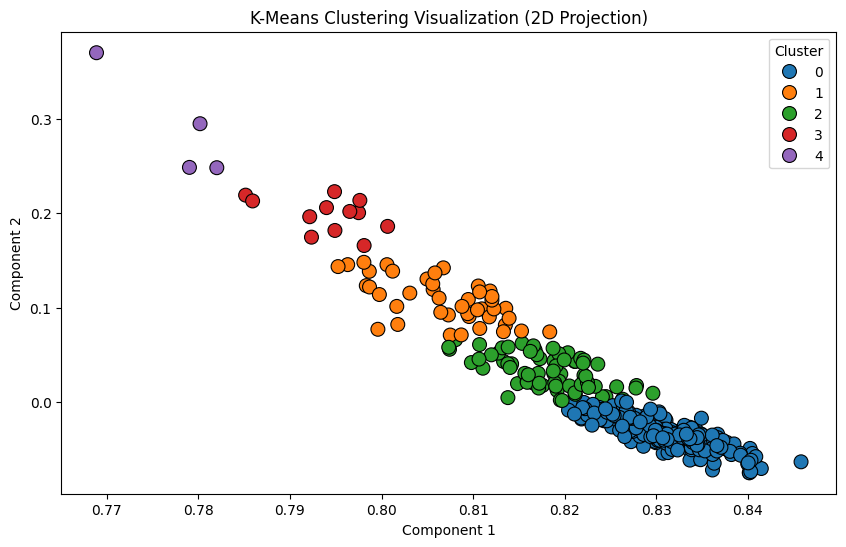

2025-03-09 16:25:57,978 : INFO : collecting all words and their counts
2025-03-09 16:25:57,979 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:25:57,981 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:25:57,987 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:25:57,988 : INFO : Creating a fresh vocabulary
2025-03-09 16:25:57,989 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:25:57.989646', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:25:57,992 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:25:57 

Finished executing at: 2025-03-09 16:25:57 

Executed at: 2025-03-09 16:25:57 



2025-03-09 16:25:58,195 : INFO : EPOCH 3: training on 24723 raw words (4761 effective words) took 0.0s, 141818 effective words/s
2025-03-09 16:25:58,265 : INFO : EPOCH 4: training on 24723 raw words (4580 effective words) took 0.1s, 81533 effective words/s
2025-03-09 16:25:58,310 : INFO : EPOCH 5: training on 24723 raw words (4660 effective words) took 0.0s, 158615 effective words/s
2025-03-09 16:25:58,372 : INFO : EPOCH 6: training on 24723 raw words (4704 effective words) took 0.0s, 97854 effective words/s
2025-03-09 16:25:58,440 : INFO : EPOCH 7: training on 24723 raw words (4666 effective words) took 0.0s, 100966 effective words/s
2025-03-09 16:25:58,501 : INFO : EPOCH 8: training on 24723 raw words (4713 effective words) took 0.0s, 117695 effective words/s
2025-03-09 16:25:58,555 : INFO : EPOCH 9: training on 24723 raw words (4693 effective words) took 0.0s, 115033 effective words/s
2025-03-09 16:25:58,601 : INFO : EPOCH 10: training on 24723 raw words (4733 effective words) took 

sg=1, Vector_Size=400, Window=5, Epoch=50
Finished displaying at: 2025-03-09 16:26:01 

Executing 5 start time: 2025-03-09 16:26:01
K=5: Silhouette Score and WSS=0.1117	1.6535

Cluster 0:
- Illegal structures razed in Lahore’s Subzazar Housing Scheme
- Credits against tax WH: FBR issuing notices to salaried individuals: KTBA
- Sabalenka, Gauff dumped out of Qatar Open
- Croatia laughter museum aims to blow away blues
- Russian drone attack damages Chernobyl shelter, Zelensky says

Cluster 1:
- Andy Cohen’s alleged leaked nudes spark debate online
- CM Maryam announces 3-marla plots for homeless people
- PGF’s ‘train the trainers program’ boosts golf coaching in Pakistan
- Couple remanded in Rawalpindi minor maid’s murder case
- Sindh minister calls for bold steps to modernise agriculture

Cluster 2:
- Israeli military killed 85 journalists in 2024: CPJ
- UK Pound further climbs up against Pakistani rupee – 14 February 2025
- Journalist killings reach record high in 2024
- Gold price so

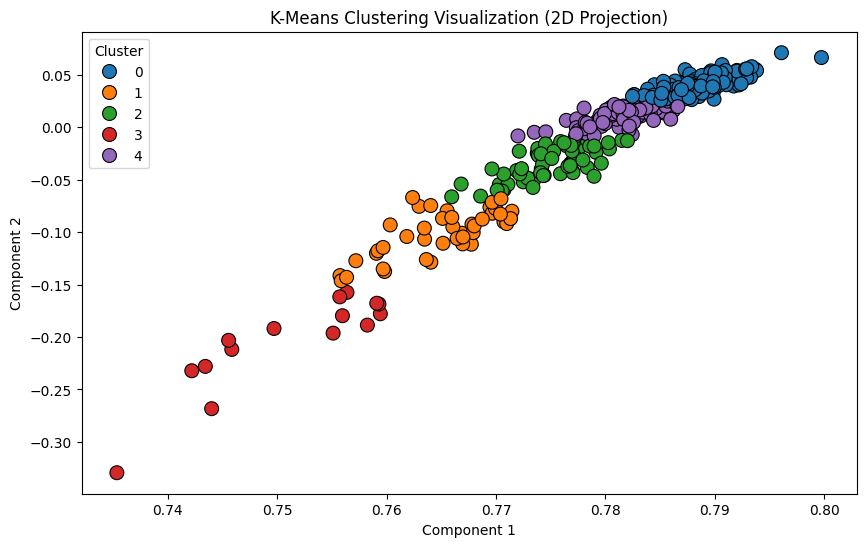

2025-03-09 16:26:01,490 : INFO : collecting all words and their counts
2025-03-09 16:26:01,491 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:01,492 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:01,495 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:01,496 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:01,497 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:01.497006', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:01,498 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:01 

Finished executing at: 2025-03-09 16:26:01 

Executed at: 2025-03-09 16:26:01 



2025-03-09 16:26:01,707 : INFO : EPOCH 6: training on 24723 raw words (4717 effective words) took 0.0s, 164731 effective words/s
2025-03-09 16:26:01,736 : INFO : EPOCH 7: training on 24723 raw words (4663 effective words) took 0.0s, 197210 effective words/s
2025-03-09 16:26:01,764 : INFO : EPOCH 8: training on 24723 raw words (4646 effective words) took 0.0s, 202502 effective words/s
2025-03-09 16:26:01,795 : INFO : EPOCH 9: training on 24723 raw words (4730 effective words) took 0.0s, 202095 effective words/s
2025-03-09 16:26:01,828 : INFO : EPOCH 10: training on 24723 raw words (4701 effective words) took 0.0s, 181732 effective words/s
2025-03-09 16:26:01,859 : INFO : EPOCH 11: training on 24723 raw words (4654 effective words) took 0.0s, 180452 effective words/s
2025-03-09 16:26:01,891 : INFO : EPOCH 12: training on 24723 raw words (4611 effective words) took 0.0s, 201409 effective words/s
2025-03-09 16:26:01,923 : INFO : EPOCH 13: training on 24723 raw words (4753 effective words) 

sg=1, Vector_Size=400, Window=7, Epoch=50
Finished displaying at: 2025-03-09 16:26:03 

Executing 5 start time: 2025-03-09 16:26:03
K=5: Silhouette Score and WSS=0.1534	1.4126

Cluster 0:
- Pak eye bright future with CT hosting
- Pakistan defeat South Africa in record chase
- Basketball star Jahki Howard caught sliding into DMs of trans influencer
- Kanye West returns to X after Antisemitic rant, fans say 'the black vans paid a visit'
- Hubco Green, PSO collaborate to setup EV charging infrastructure across Pakistan

Cluster 1:
- Term of incumbent Ogra chairman set to expire but search for replacement not in sight
- Challenges hinder Gwadar Port’s full-scale operations despite incentives: report
- Pakistan keen to increase trade, investment with Japan: Governor
- Karachi police unveil traffic and parking plan for tri-series, Champions Trophy
- From Aztec Ritual to Valentine’s Day Staple: The Rise of Chocolate Gifts

Cluster 2:
- Pakistan’s 2nd polio case of 2025 reported in Badin
- Isr

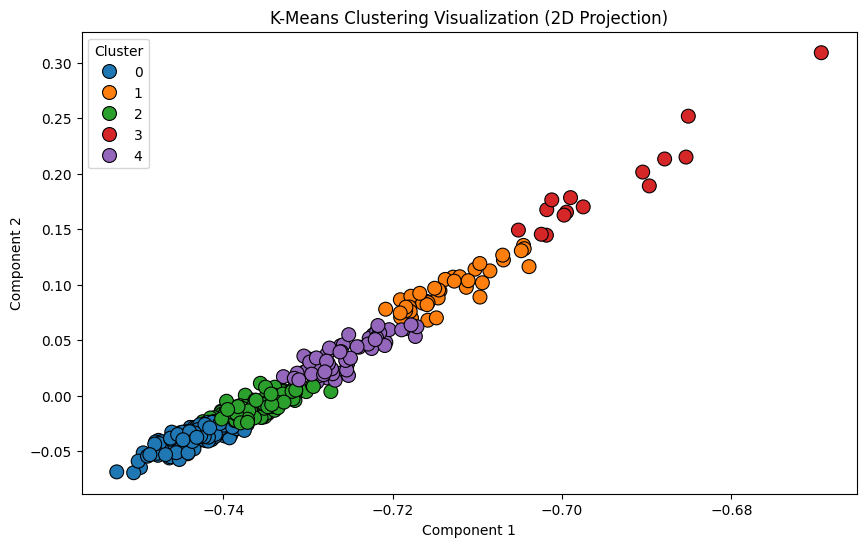

2025-03-09 16:26:03,783 : INFO : collecting all words and their counts
2025-03-09 16:26:03,784 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:03,784 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:03,791 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:03,794 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:03,795 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:03.795470', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:03,797 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:03 

Finished executing at: 2025-03-09 16:26:03 

Executed at: 2025-03-09 16:26:03 



2025-03-09 16:26:03,987 : INFO : EPOCH 3: training on 24723 raw words (4726 effective words) took 0.0s, 128676 effective words/s
2025-03-09 16:26:04,029 : INFO : EPOCH 4: training on 24723 raw words (4665 effective words) took 0.0s, 130180 effective words/s
2025-03-09 16:26:04,073 : INFO : EPOCH 5: training on 24723 raw words (4692 effective words) took 0.0s, 137209 effective words/s
2025-03-09 16:26:04,114 : INFO : EPOCH 6: training on 24723 raw words (4644 effective words) took 0.0s, 129666 effective words/s
2025-03-09 16:26:04,154 : INFO : EPOCH 7: training on 24723 raw words (4635 effective words) took 0.0s, 151080 effective words/s
2025-03-09 16:26:04,197 : INFO : EPOCH 8: training on 24723 raw words (4660 effective words) took 0.0s, 125798 effective words/s
2025-03-09 16:26:04,237 : INFO : EPOCH 9: training on 24723 raw words (4611 effective words) took 0.0s, 132824 effective words/s
2025-03-09 16:26:04,282 : INFO : EPOCH 10: training on 24723 raw words (4618 effective words) too

sg=1, Vector_Size=400, Window=10, Epoch=50
Finished displaying at: 2025-03-09 16:26:06 

Executing 5 start time: 2025-03-09 16:26:06
K=5: Silhouette Score and WSS=0.0988	1.3086

Cluster 0:
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- CJP Afridi administers oath to newly-appointed SC judges
- Kanye West returns to X after Antisemitic rant, fans say 'the black vans paid a visit'
- Taco Bell security guard caught on video slapping female customer in shocking incident
- Mehwish Hayat is making her TV comeback with a dark, chilling role for 7th Sky Entertainment

Cluster 1:
- TikTok’s Back in the Game! The Viral App Finally Returns to U.S. App Stores!
- Non-banking microfinance sector: SECP announces series of initiatives to empower women, strengthen consumer protection
- Sabrina Carpenter and Dolly Parton’s 'Please Please Please' remix takes an unexpected turn in new video
- DeepSeek dilemma: Why is the Chinese AI app facing global backlash?
- Is Urfi Javed engaged? ph

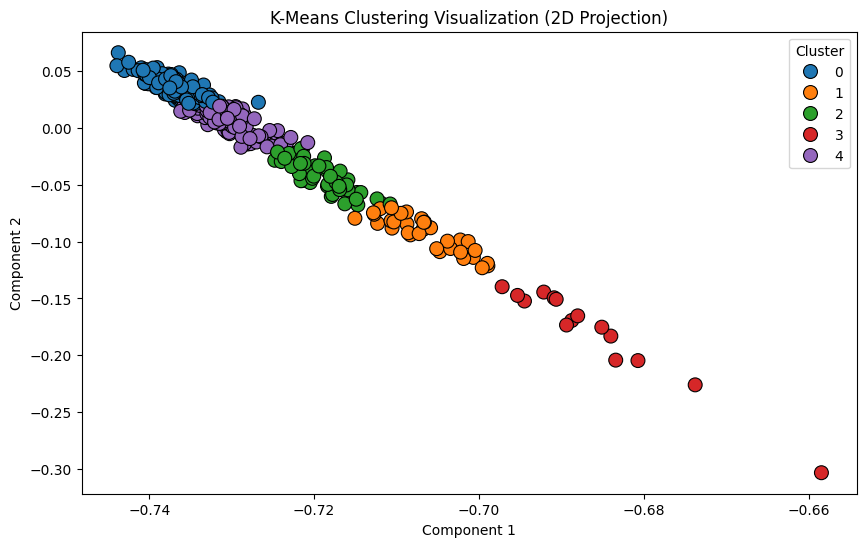

2025-03-09 16:26:06,915 : INFO : collecting all words and their counts
2025-03-09 16:26:06,916 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:06,918 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:06,925 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:06,926 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:06,928 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:06.928997', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:06,930 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:06 

Finished executing at: 2025-03-09 16:26:06 

Executed at: 2025-03-09 16:26:06 



2025-03-09 16:26:07,096 : INFO : EPOCH 2: training on 24723 raw words (4603 effective words) took 0.0s, 108440 effective words/s
2025-03-09 16:26:07,169 : INFO : EPOCH 3: training on 24723 raw words (4722 effective words) took 0.1s, 73575 effective words/s
2025-03-09 16:26:07,235 : INFO : EPOCH 4: training on 24723 raw words (4759 effective words) took 0.1s, 80295 effective words/s
2025-03-09 16:26:07,323 : INFO : EPOCH 5: training on 24723 raw words (4725 effective words) took 0.1s, 83182 effective words/s
2025-03-09 16:26:07,400 : INFO : EPOCH 6: training on 24723 raw words (4669 effective words) took 0.1s, 87845 effective words/s
2025-03-09 16:26:07,459 : INFO : EPOCH 7: training on 24723 raw words (4630 effective words) took 0.0s, 93001 effective words/s
2025-03-09 16:26:07,522 : INFO : EPOCH 8: training on 24723 raw words (4656 effective words) took 0.1s, 86686 effective words/s
2025-03-09 16:26:07,605 : INFO : EPOCH 9: training on 24723 raw words (4692 effective words) took 0.1s,

sg=1, Vector_Size=400, Window=12, Epoch=50
Finished displaying at: 2025-03-09 16:26:09 

Executing 5 start time: 2025-03-09 16:26:09
K=5: Silhouette Score and WSS=0.1272	1.2241

Cluster 0:
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- Pakistan's reference in Indo-US statement misleading; can't cover-up India's terror sponsorship: FO
- Challenges hinder Gwadar Port’s full-scale operations despite incentives: report
- From Aztec Ritual to Valentine’s Day Staple: The Rise of Chocolate Gifts
- Law ministry notifies appointments of six SC judges, four high court chief justices

Cluster 1:
- PIA financial closure deadline shortened by 4 months
- 7 Beauty Secrets Celebrities Swear By (And How You Can Steal Them!)
- Page World Economy and Politics News ISB Page 5
- PMDC, Kazakh govt vow to cooperate in medical education
- PPL executes agreements for Sui Gas Field operations

Cluster 2:
- Gold price soars by Rs2,500 per tola
- Solar panel imports: 80 companies transferred ar

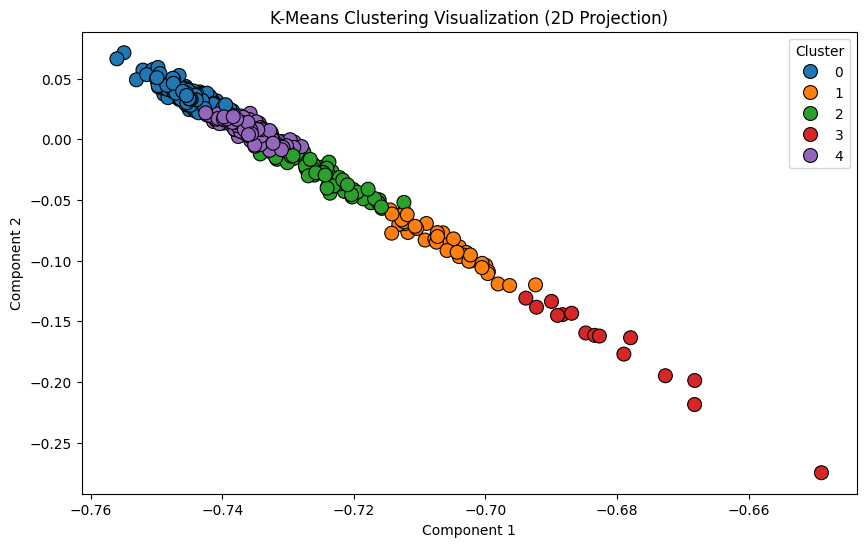

2025-03-09 16:26:10,264 : INFO : collecting all words and their counts
2025-03-09 16:26:10,265 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:10,266 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:10,272 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:10,273 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:10,274 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:10.274976', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:10,276 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:10 

Finished executing at: 2025-03-09 16:26:10 

Executed at: 2025-03-09 16:26:10 



2025-03-09 16:26:10,486 : INFO : EPOCH 3: training on 24723 raw words (4727 effective words) took 0.0s, 106840 effective words/s
2025-03-09 16:26:10,544 : INFO : EPOCH 4: training on 24723 raw words (4702 effective words) took 0.1s, 93635 effective words/s
2025-03-09 16:26:10,601 : INFO : EPOCH 5: training on 24723 raw words (4683 effective words) took 0.0s, 95839 effective words/s
2025-03-09 16:26:10,653 : INFO : EPOCH 6: training on 24723 raw words (4578 effective words) took 0.0s, 104379 effective words/s
2025-03-09 16:26:10,727 : INFO : EPOCH 7: training on 24723 raw words (4580 effective words) took 0.1s, 73210 effective words/s
2025-03-09 16:26:10,793 : INFO : EPOCH 8: training on 24723 raw words (4780 effective words) took 0.1s, 92825 effective words/s
2025-03-09 16:26:10,851 : INFO : EPOCH 9: training on 24723 raw words (4603 effective words) took 0.0s, 101740 effective words/s
2025-03-09 16:26:10,918 : INFO : EPOCH 10: training on 24723 raw words (4691 effective words) took 0.

sg=1, Vector_Size=400, Window=15, Epoch=50
Finished displaying at: 2025-03-09 16:26:15 

Executing 5 start time: 2025-03-09 16:26:15
K=5: Silhouette Score and WSS=0.1006	1.1964

Cluster 0:
- PMDC, Kazakh govt vow to cooperate in medical education
- CJP Afridi administers oath to newly-appointed SC judges
- Catherine Zeta-Jones to star in revenge thriller series Kill Jackie based on Nick Harkaway's novel
- Soulja Boy drags Marlon Wayans’ dead mother in ongoing beef
- Conspiracy theorist Gabbard confirmed as new US spy chief

Cluster 1:
- PA pre-budget debate overshadowed by lawmakers’ apathy
- Explosion near security convoy in Bannu injures two personnel
- Second death anniversary of Zia Mohyeddin observed
- Karachi sees surge in traffic accidents as govt moves to strengthen road safety
- Senate body vows to continue probing solar panel import scandal

Cluster 2:
- Israel says Hamas must free three living hostages
- Marwat reaffirms unwavering loyalty to Imran Khan
- U.S. deports migran

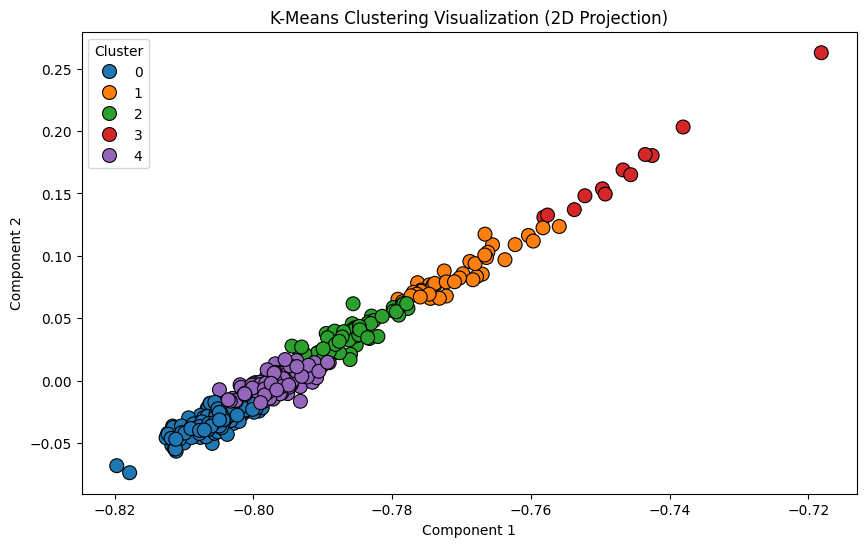

2025-03-09 16:26:16,505 : INFO : collecting all words and their counts
2025-03-09 16:26:16,509 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:16,513 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:16,528 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:16,533 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:16,537 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:16.536144', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:16,539 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:16 

Finished executing at: 2025-03-09 16:26:16 

Executed at: 2025-03-09 16:26:16 



2025-03-09 16:26:16,808 : INFO : EPOCH 1: training on 24723 raw words (4579 effective words) took 0.1s, 40558 effective words/s
2025-03-09 16:26:16,932 : INFO : EPOCH 2: training on 24723 raw words (4628 effective words) took 0.1s, 41959 effective words/s
2025-03-09 16:26:17,070 : INFO : EPOCH 3: training on 24723 raw words (4800 effective words) took 0.1s, 38795 effective words/s
2025-03-09 16:26:17,199 : INFO : EPOCH 4: training on 24723 raw words (4714 effective words) took 0.1s, 40547 effective words/s
2025-03-09 16:26:17,334 : INFO : EPOCH 5: training on 24723 raw words (4709 effective words) took 0.1s, 39538 effective words/s
2025-03-09 16:26:17,449 : INFO : EPOCH 6: training on 24723 raw words (4629 effective words) took 0.1s, 44431 effective words/s
2025-03-09 16:26:17,563 : INFO : EPOCH 7: training on 24723 raw words (4652 effective words) took 0.1s, 46380 effective words/s
2025-03-09 16:26:17,681 : INFO : EPOCH 8: training on 24723 raw words (4761 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=20, Epoch=50
Finished displaying at: 2025-03-09 16:26:22 

Executing 5 start time: 2025-03-09 16:26:22
K=5: Silhouette Score and WSS=0.1101	1.1627

Cluster 0:
- KU VC Prof Dr Khalid Iraqi inaugurates second agricultural festival
- HBL, S&P Global launch Pakistan’s first manufacturing PMI
- Bureaucrats will also have to declare their assets
- Azaan Sami Khan pens birthday note for daughter
- Russian drone attack damages Chernobyl shelter, Zelensky says

Cluster 1:
- Karachi sees surge in traffic accidents as govt moves to strengthen road safety
- Harassment experiences in Pakistan: the need to speak up
- Sharaa speaks of ‘strong strategic ties’ with Russia in Putin phone call
- Justice Jahangiri declares writing advocate on vehicles' number plates illegal
- #IStandWithSandiePeggie: Nurse Sandie Peggie speaks out amid NHS Fife women’s changing room scandal

Cluster 2:
- Hamas vows to uphold truce, plans to proceed with hostage-prisoner swap
- 7 Beauty Secret

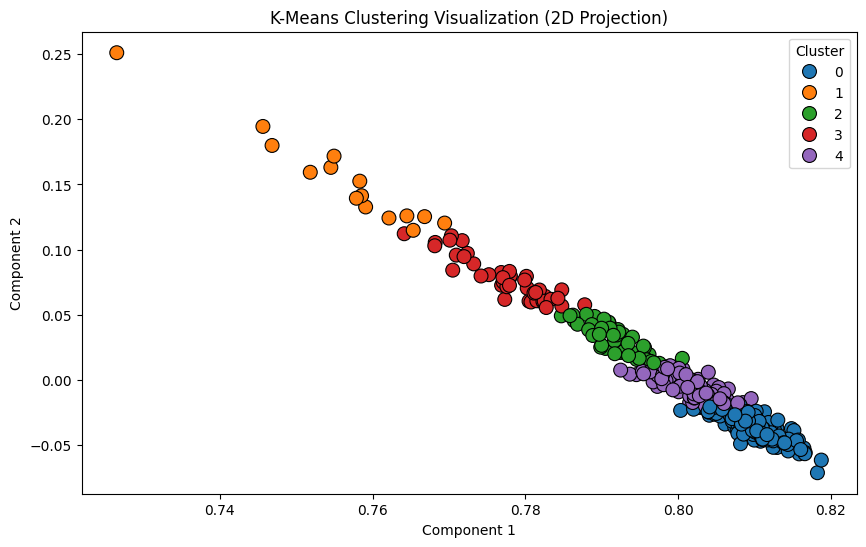

Finished displaying at: 2025-03-09 16:26:23 

Finished executing at: 2025-03-09 16:26:23 



In [923]:
best_combination, best_Sil, best_WSS = run_combinations(5, best_combination, best_Sil, best_WSS)

2025-03-09 16:26:23,299 : INFO : collecting all words and their counts
2025-03-09 16:26:23,303 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:23,307 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:23,320 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:23,324 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:23,330 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:23.329949', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:23,335 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Executed at: 2025-03-09 16:26:23 



2025-03-09 16:26:23,458 : INFO : EPOCH 0: training on 24723 raw words (4636 effective words) took 0.1s, 88379 effective words/s
2025-03-09 16:26:23,528 : INFO : EPOCH 1: training on 24723 raw words (4650 effective words) took 0.1s, 84168 effective words/s
2025-03-09 16:26:23,603 : INFO : EPOCH 2: training on 24723 raw words (4657 effective words) took 0.1s, 81819 effective words/s
2025-03-09 16:26:23,677 : INFO : EPOCH 3: training on 24723 raw words (4628 effective words) took 0.1s, 81882 effective words/s
2025-03-09 16:26:23,758 : INFO : EPOCH 4: training on 24723 raw words (4729 effective words) took 0.1s, 76237 effective words/s
2025-03-09 16:26:23,839 : INFO : EPOCH 5: training on 24723 raw words (4703 effective words) took 0.1s, 74140 effective words/s
2025-03-09 16:26:23,920 : INFO : EPOCH 6: training on 24723 raw words (4660 effective words) took 0.1s, 74443 effective words/s
2025-03-09 16:26:23,997 : INFO : EPOCH 7: training on 24723 raw words (4648 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=3, Epoch=50
Finished displaying at: 2025-03-09 16:26:27 

Executing 9 start time: 2025-03-09 16:26:27
K=9: Silhouette Score and WSS=0.0979	1.6851

Cluster 0:
- South African rand firms after Trump’s tariff move; local budget next week
- If love hurts, the Sufis say you’re doing it right
- Three Pakistani players fined for ICC code of conduct breach
- KU VC Prof Dr Khalid Iraqi inaugurates second agricultural festival
- Justice Mansoor Ali Shah dismisses reference fears, highlights judiciary’s performance

Cluster 1:
- Intra-party: elections case ECP directs PPP to submit response
- Harassment experiences in Pakistan: the need to speak up
- PA pre-budget debate overshadowed by lawmakers’ apathy
- Mohsin Naqvi announces three-day spring festival in Islamabad
- Pakistan defeat South Africa in record chase

Cluster 2:
- Second polio case of 2025 reported from Badin
- Gold adds to record rally, reaches Rs306,200 per tola in Pakistan
- Stocks remain range-bound,

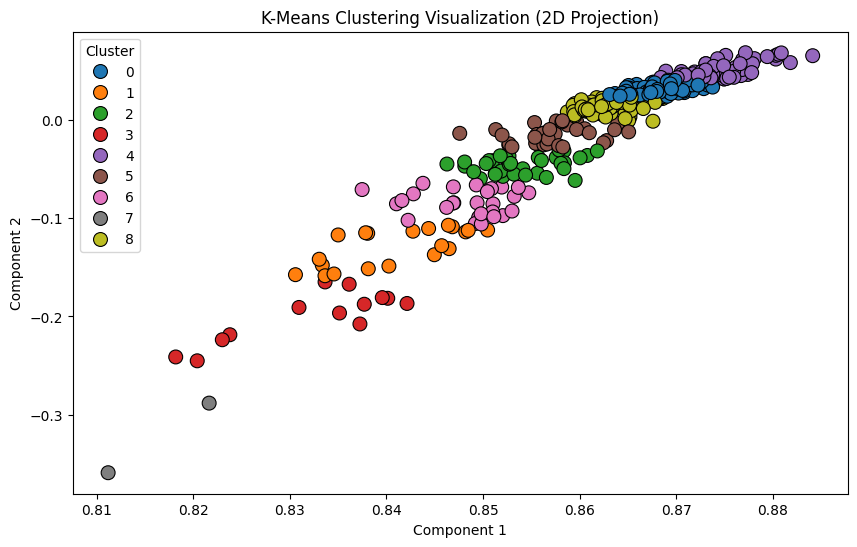

2025-03-09 16:26:28,326 : INFO : collecting all words and their counts
2025-03-09 16:26:28,329 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:28,332 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:28,342 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:28,344 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:28,347 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:28.347079', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:28,350 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:28 

Finished executing at: 2025-03-09 16:26:28 

Executed at: 2025-03-09 16:26:28 



2025-03-09 16:26:28,542 : INFO : EPOCH 1: training on 24723 raw words (4645 effective words) took 0.1s, 74395 effective words/s
2025-03-09 16:26:28,628 : INFO : EPOCH 2: training on 24723 raw words (4579 effective words) took 0.1s, 65008 effective words/s
2025-03-09 16:26:28,726 : INFO : EPOCH 3: training on 24723 raw words (4652 effective words) took 0.1s, 66074 effective words/s
2025-03-09 16:26:28,794 : INFO : EPOCH 4: training on 24723 raw words (4638 effective words) took 0.1s, 89249 effective words/s
2025-03-09 16:26:28,866 : INFO : EPOCH 5: training on 24723 raw words (4692 effective words) took 0.1s, 85930 effective words/s
2025-03-09 16:26:28,935 : INFO : EPOCH 6: training on 24723 raw words (4665 effective words) took 0.1s, 83050 effective words/s
2025-03-09 16:26:29,010 : INFO : EPOCH 7: training on 24723 raw words (4630 effective words) took 0.1s, 75553 effective words/s
2025-03-09 16:26:29,086 : INFO : EPOCH 8: training on 24723 raw words (4793 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=5, Epoch=50
Finished displaying at: 2025-03-09 16:26:32 

Executing 9 start time: 2025-03-09 16:26:32
K=9: Silhouette Score and WSS=0.1036	1.3098

Cluster 0:
- JD Vance says US wields economic, military leverage on Russia in Ukraine talks
- Everyone can’t go to jail to meet Imran: IHC CJ
- UEFA Champions League playoffs: Bayern, Benfica in ideal position
- JUI-F chief stands with journalists against PECA law
- Paramount channels, including CBS and Nickelodeon, to go dark on YouTube TV

Cluster 1:
- Man slays 4 kids before turning gun on himself
- Illegal structures razed in Lahore’s Subzazar Housing Scheme
- PIA upbeat about resumption of UK flights
- Field of education: Pakistan, Kazakhstan for enhancing mutual cooperation
- Watch: Humpback whale swallows kayaker in dramatic Chilean waters encounter

Cluster 2:
- Islamabad’s Zones 2, 4, and 5: CDA forms joint body to oversee projects
- Wasim Akram joins Meer Group to drive Global Impact Vision 2030
- Raja

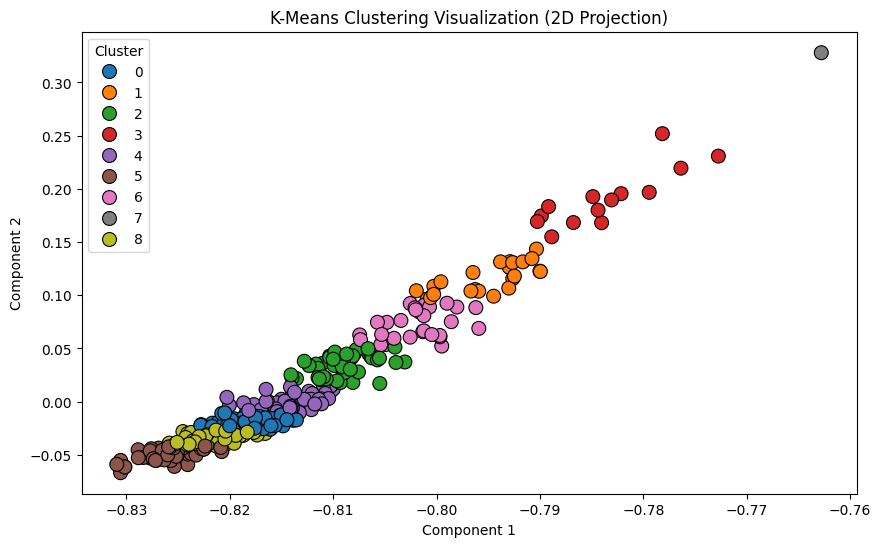

2025-03-09 16:26:33,448 : INFO : collecting all words and their counts
2025-03-09 16:26:33,450 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:33,452 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:33,460 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:33,465 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:33,469 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:33.469200', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:33,472 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:33 

Finished executing at: 2025-03-09 16:26:33 

Executed at: 2025-03-09 16:26:33 



2025-03-09 16:26:33,661 : INFO : EPOCH 1: training on 24723 raw words (4661 effective words) took 0.1s, 73881 effective words/s
2025-03-09 16:26:33,738 : INFO : EPOCH 2: training on 24723 raw words (4633 effective words) took 0.1s, 76298 effective words/s
2025-03-09 16:26:33,810 : INFO : EPOCH 3: training on 24723 raw words (4759 effective words) took 0.1s, 82599 effective words/s
2025-03-09 16:26:33,887 : INFO : EPOCH 4: training on 24723 raw words (4641 effective words) took 0.1s, 79078 effective words/s
2025-03-09 16:26:33,968 : INFO : EPOCH 5: training on 24723 raw words (4673 effective words) took 0.1s, 67452 effective words/s
2025-03-09 16:26:34,046 : INFO : EPOCH 6: training on 24723 raw words (4663 effective words) took 0.1s, 69934 effective words/s
2025-03-09 16:26:34,121 : INFO : EPOCH 7: training on 24723 raw words (4667 effective words) took 0.1s, 74768 effective words/s
2025-03-09 16:26:34,203 : INFO : EPOCH 8: training on 24723 raw words (4696 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=7, Epoch=50
Finished displaying at: 2025-03-09 16:26:37 

Executing 9 start time: 2025-03-09 16:26:37
K=9: Silhouette Score and WSS=0.1016	1.2221

Cluster 0:
- Saudi Arabia to host Arab summit on Trump’s Gaza plan
- Sabalenka, Gauff dumped out of Qatar Open
- Burnt body of missing Karachi young man found
- Aurangzeb highlights increasing risks facing insurance industry
- Dear Pakistani Men, Please Stop Making Rakhi Sawant Cry

Cluster 1:
- House Democrats urge Trump to retract comments on Gaza
- Fashion designer Mehmood Bhatti alleges assault by lawyers in Lahore court
- Economic indicators showing positive trends, says Khurram Schehzad
- Russian drone attack damages Chernobyl shelter, Zelensky says
- Michael Kors rounds out New York Fashion Week

Cluster 2:
- Trump says US has approved extradition of suspect in 2008 Mumbai attacks
- Rajat Patidar named RCB captain for IPL 2025 as Virat Kohli gets snubbed
- More than 500 million take ‘holy dip’ in India’s 

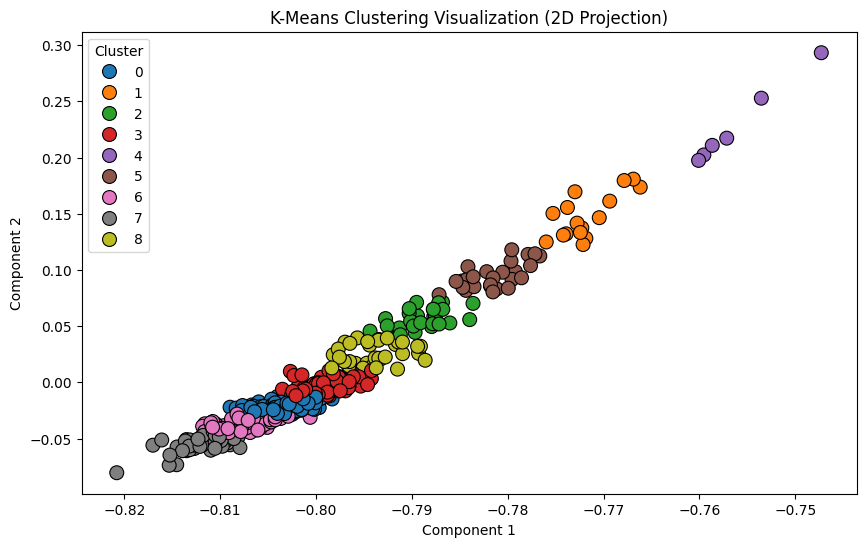

2025-03-09 16:26:38,515 : INFO : collecting all words and their counts
2025-03-09 16:26:38,517 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:38,519 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:38,530 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:38,533 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:38,542 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:38.542184', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:38,546 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:38 

Finished executing at: 2025-03-09 16:26:38 

Executed at: 2025-03-09 16:26:38 



2025-03-09 16:26:38,808 : INFO : EPOCH 1: training on 24723 raw words (4656 effective words) took 0.1s, 46505 effective words/s
2025-03-09 16:26:38,913 : INFO : EPOCH 2: training on 24723 raw words (4633 effective words) took 0.1s, 51606 effective words/s
2025-03-09 16:26:39,017 : INFO : EPOCH 3: training on 24723 raw words (4728 effective words) took 0.1s, 53345 effective words/s
2025-03-09 16:26:39,111 : INFO : EPOCH 4: training on 24723 raw words (4695 effective words) took 0.1s, 57356 effective words/s
2025-03-09 16:26:39,204 : INFO : EPOCH 5: training on 24723 raw words (4814 effective words) took 0.1s, 61565 effective words/s
2025-03-09 16:26:39,298 : INFO : EPOCH 6: training on 24723 raw words (4669 effective words) took 0.1s, 57137 effective words/s
2025-03-09 16:26:39,414 : INFO : EPOCH 7: training on 24723 raw words (4680 effective words) took 0.1s, 48367 effective words/s
2025-03-09 16:26:39,520 : INFO : EPOCH 8: training on 24723 raw words (4726 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=10, Epoch=50
Finished displaying at: 2025-03-09 16:26:43 

Executing 9 start time: 2025-03-09 16:26:43
K=9: Silhouette Score and WSS=0.1008	1.0597

Cluster 0:
- Gazans return to ruined homes and severe water shortage
- CJP Yahya Afridi administers oath to six newly appointed SC judges
- Pakistan defeat South Africa in record chase
- KU VC Prof Dr Khalid Iraqi inaugurates second agricultural festival
- Aurangzeb highlights increasing risks facing insurance industry

Cluster 1:
- Mariyam Nafees’ husband’s past marriage surprises fan
- Sher Afzal Marwat's 'Mujhe kyun nikala?' question sparks laughter in NA
- I want to become a UFC World Champion, Bano Butt on her dreams and breaking barriers
- DeepSeek dilemma: Why is the Chinese AI app facing global backlash?
- Europe warns Trump against Ukraine deal ‘behind our backs’

Cluster 2:
- Pakistan’s 2nd polio case of 2025 reported in Badin
- Israeli military killed 85 journalists in 2024: CPJ
- Feb 14 last date to

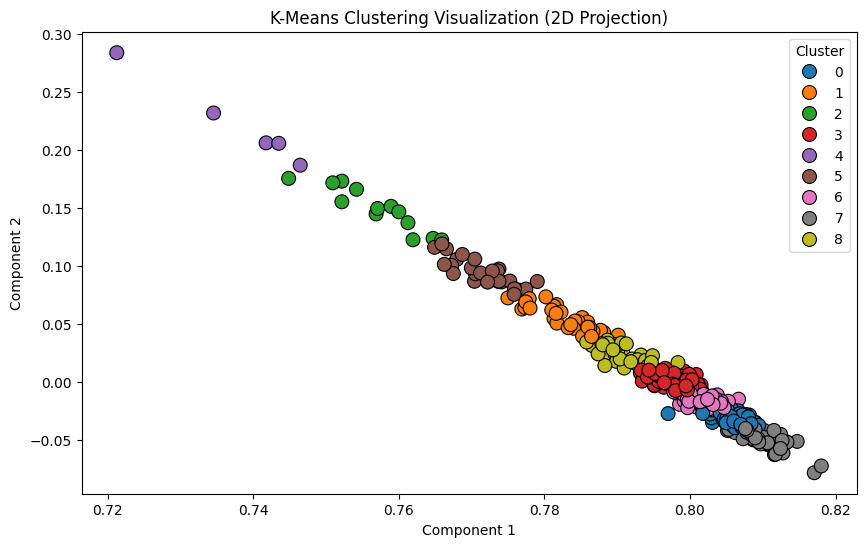

2025-03-09 16:26:44,411 : INFO : collecting all words and their counts
2025-03-09 16:26:44,413 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:44,414 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:44,424 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:44,426 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:44,429 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:44.429405', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:44,432 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:44 

Finished executing at: 2025-03-09 16:26:44 

Executed at: 2025-03-09 16:26:44 



2025-03-09 16:26:44,630 : INFO : EPOCH 1: training on 24723 raw words (4634 effective words) took 0.1s, 68629 effective words/s
2025-03-09 16:26:44,717 : INFO : EPOCH 2: training on 24723 raw words (4741 effective words) took 0.1s, 62751 effective words/s
2025-03-09 16:26:44,798 : INFO : EPOCH 3: training on 24723 raw words (4658 effective words) took 0.1s, 65736 effective words/s
2025-03-09 16:26:44,880 : INFO : EPOCH 4: training on 24723 raw words (4729 effective words) took 0.1s, 67225 effective words/s
2025-03-09 16:26:44,963 : INFO : EPOCH 5: training on 24723 raw words (4626 effective words) took 0.1s, 63065 effective words/s
2025-03-09 16:26:45,031 : INFO : EPOCH 6: training on 24723 raw words (4665 effective words) took 0.1s, 80899 effective words/s
2025-03-09 16:26:45,124 : INFO : EPOCH 7: training on 24723 raw words (4652 effective words) took 0.1s, 58212 effective words/s
2025-03-09 16:26:45,214 : INFO : EPOCH 8: training on 24723 raw words (4722 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=12, Epoch=50
Finished displaying at: 2025-03-09 16:26:49 

Executing 9 start time: 2025-03-09 16:26:49
K=9: Silhouette Score and WSS=0.0858	1.0743

Cluster 0:
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- Everyone can’t go to jail to meet Imran: IHC CJ
- Hasan Raheem softens down his song 'Obvious'
- JUI-F chief stands with journalists against PECA law
- Pakistan’s greatest ODI chases: A look back after historic win over South Africa

Cluster 1:
- Gazans return to ruined homes and severe water shortage
- PMDC, Kazakh govt vow to cooperate in medical education
- Non-banking microfinance sector: SECP announces series of initiatives to empower women, strengthen consumer protection
- HBL and S&P launch Pakistan’s first Purchasing Managers’ Index
- Pakistan defeat South Africa in record chase

Cluster 2:
- UAE is offering 10-Year Visa; Guide for Pakistanis to apply in 2025
- SBP reserves fall $500m in less than a month | Dawn News English


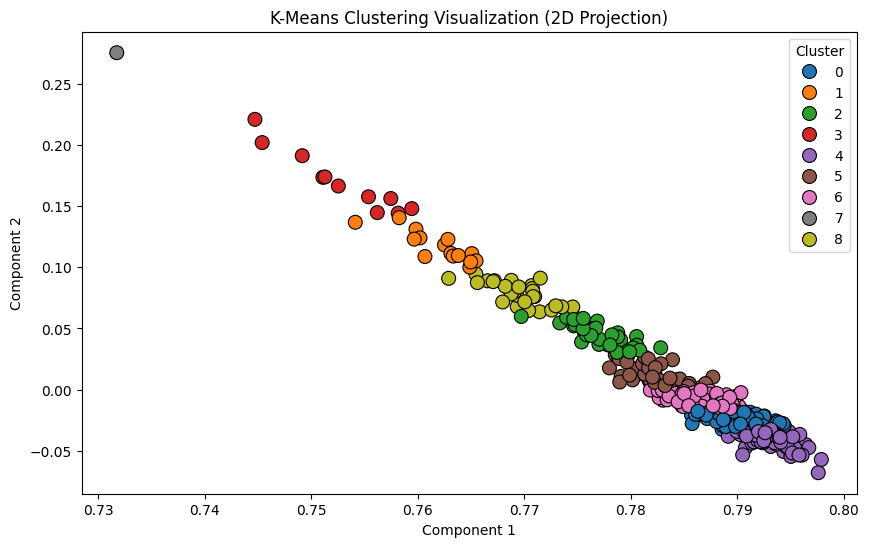

2025-03-09 16:26:50,277 : INFO : collecting all words and their counts
2025-03-09 16:26:50,280 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:50,283 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:50,306 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:50,316 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:50,324 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:50.324582', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:50,334 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:50 

Finished executing at: 2025-03-09 16:26:50 

Executed at: 2025-03-09 16:26:50 



2025-03-09 16:26:50,601 : INFO : EPOCH 0: training on 24723 raw words (4635 effective words) took 0.2s, 30191 effective words/s
2025-03-09 16:26:50,757 : INFO : EPOCH 1: training on 24723 raw words (4842 effective words) took 0.1s, 36626 effective words/s
2025-03-09 16:26:50,853 : INFO : EPOCH 2: training on 24723 raw words (4648 effective words) took 0.1s, 55830 effective words/s
2025-03-09 16:26:50,942 : INFO : EPOCH 3: training on 24723 raw words (4736 effective words) took 0.1s, 58536 effective words/s
2025-03-09 16:26:51,037 : INFO : EPOCH 4: training on 24723 raw words (4681 effective words) took 0.1s, 57350 effective words/s
2025-03-09 16:26:51,132 : INFO : EPOCH 5: training on 24723 raw words (4678 effective words) took 0.1s, 55535 effective words/s
2025-03-09 16:26:51,227 : INFO : EPOCH 6: training on 24723 raw words (4662 effective words) took 0.1s, 58834 effective words/s
2025-03-09 16:26:51,313 : INFO : EPOCH 7: training on 24723 raw words (4667 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=15, Epoch=50
Finished displaying at: 2025-03-09 16:26:55 

Executing 9 start time: 2025-03-09 16:26:55
K=9: Silhouette Score and WSS=0.1014	1.0351

Cluster 0:
- Pakistan’s greatest ODI chases: A look back after historic win over South Africa
- Karachi police unveil traffic and parking plan for tri-series, Champions Trophy
- Senate Dy Chairman, Balochistan CM discuss development projects
- Paramount and youtube clash over contract, channels may be dropped
- From Napa to Rada: Actor Hani Taha’s journey to the world’s premier drama school

Cluster 1:
- Rs10bn defamation suit: LHC seeks more arguments on IK’s plea
- Top global funds turn to Pakistan as 84% stock rally set to continue: Bloomberg
- Togg T10X, Turkey's first national electric SUV
- Pakistan Software Export Board expands IT infrastructure with 43 technology parks
- Pope Francis, 88, admitted for bronchitis treatment after struggling to speak

Cluster 2:
- Pakistan’s 2nd polio case of 2025 reported

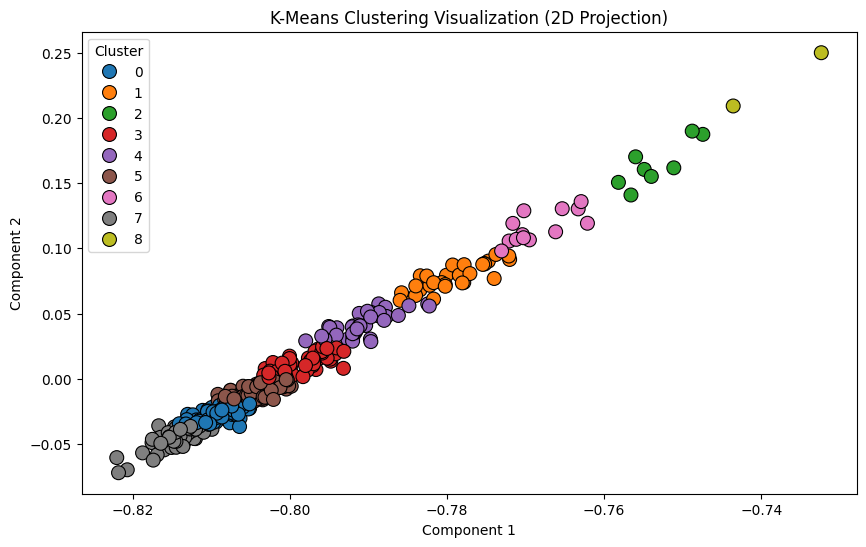

2025-03-09 16:26:56,366 : INFO : collecting all words and their counts
2025-03-09 16:26:56,369 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:26:56,373 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:26:56,386 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:26:56,391 : INFO : Creating a fresh vocabulary
2025-03-09 16:26:56,394 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:26:56.394654', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:26:56,397 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:26:56 

Finished executing at: 2025-03-09 16:26:56 

Executed at: 2025-03-09 16:26:56 



2025-03-09 16:26:56,574 : INFO : EPOCH 0: training on 24723 raw words (4650 effective words) took 0.1s, 45155 effective words/s
2025-03-09 16:26:56,690 : INFO : EPOCH 1: training on 24723 raw words (4673 effective words) took 0.1s, 45529 effective words/s
2025-03-09 16:26:56,798 : INFO : EPOCH 2: training on 24723 raw words (4673 effective words) took 0.1s, 49755 effective words/s
2025-03-09 16:26:56,922 : INFO : EPOCH 3: training on 24723 raw words (4666 effective words) took 0.1s, 44671 effective words/s
2025-03-09 16:26:57,030 : INFO : EPOCH 4: training on 24723 raw words (4661 effective words) took 0.1s, 48545 effective words/s
2025-03-09 16:26:57,128 : INFO : EPOCH 5: training on 24723 raw words (4765 effective words) took 0.1s, 54380 effective words/s
2025-03-09 16:26:57,230 : INFO : EPOCH 6: training on 24723 raw words (4685 effective words) took 0.1s, 51931 effective words/s
2025-03-09 16:26:57,332 : INFO : EPOCH 7: training on 24723 raw words (4657 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=20, Epoch=50
Finished displaying at: 2025-03-09 16:27:01 

Executing 9 start time: 2025-03-09 16:27:01
K=9: Silhouette Score and WSS=0.0941	0.9790

Cluster 0:
- Minister takes notice of difficulties in Umrah vaccination, orders more counters
- Injuries disrupted England’s training during India ODI series: McCullum
- Haveli of Maharaja Ranjit Singh being conserved by WCLA
- Aurangzeb highlights increasing risks facing insurance industry
- South African rand firms after Trump’s tariff move; local budget next week

Cluster 1:
- 9 Nail Polish Shades to Fall in Love With This Valentine’s Day
- Man shoots himself dead after killing 4 children in Swabi: officials
- Pakistan set 243-run target for New Zealand in Tri-Nation series final
- Drake addresses rap beef with Joe Budden and Kendrick Lamar on new song 'Gimme a Hug'
- Elahi’s plea: AC reserves verdict till 27th

Cluster 2:
- KP govt prepares to launch first air ambulance service
- Kanye West gets sued over a

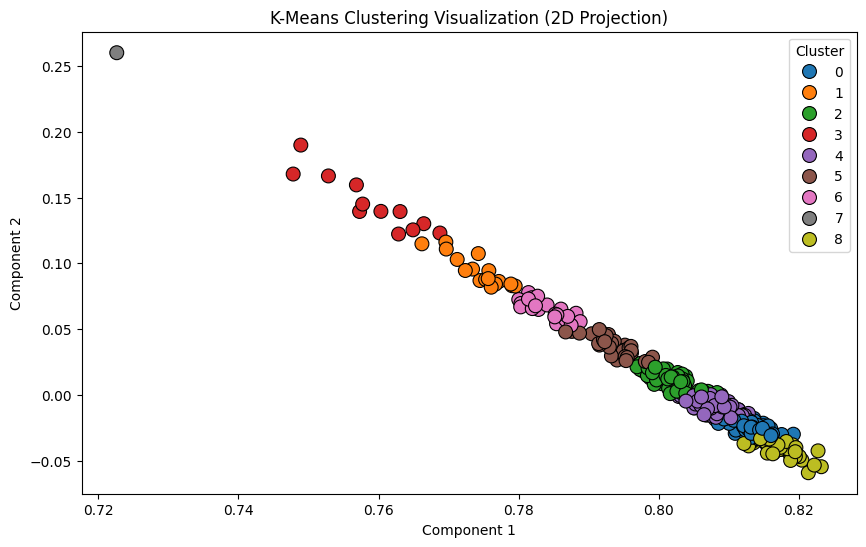

Finished displaying at: 2025-03-09 16:27:02 

Finished executing at: 2025-03-09 16:27:02 



In [924]:
best_combination, best_Sil, best_WSS = run_combinations(9, best_combination, best_Sil, best_WSS)

2025-03-09 16:27:02,988 : INFO : collecting all words and their counts
2025-03-09 16:27:02,994 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:02,998 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:03,016 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:03,023 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:03,027 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:03.027338', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:03,032 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Executed at: 2025-03-09 16:27:02 



2025-03-09 16:27:03,150 : INFO : EPOCH 0: training on 24723 raw words (4636 effective words) took 0.0s, 97030 effective words/s
2025-03-09 16:27:03,202 : INFO : EPOCH 1: training on 24723 raw words (4624 effective words) took 0.0s, 125801 effective words/s
2025-03-09 16:27:03,342 : INFO : EPOCH 2: training on 24723 raw words (4780 effective words) took 0.1s, 49331 effective words/s
2025-03-09 16:27:03,461 : INFO : EPOCH 3: training on 24723 raw words (4602 effective words) took 0.1s, 76408 effective words/s
2025-03-09 16:27:03,577 : INFO : EPOCH 4: training on 24723 raw words (4731 effective words) took 0.1s, 77385 effective words/s
2025-03-09 16:27:03,649 : INFO : EPOCH 5: training on 24723 raw words (4630 effective words) took 0.0s, 112044 effective words/s
2025-03-09 16:27:03,716 : INFO : EPOCH 6: training on 24723 raw words (4724 effective words) took 0.1s, 90166 effective words/s
2025-03-09 16:27:03,784 : INFO : EPOCH 7: training on 24723 raw words (4627 effective words) took 0.0s

sg=1, Vector_Size=400, Window=3, Epoch=50
Finished displaying at: 2025-03-09 16:27:06 

Executing 13 start time: 2025-03-09 16:27:06
K=13: Silhouette Score and WSS=0.0893	1.5016

Cluster 0:
- Economist Stiglitz urges tariffs on Trump’s ‘dysfunctional’ admin
- Aurangzeb discusses Pakistan’s structural reforms with IFC chief
- South African rand firms after Trump’s tariff move; local budget next week
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- ‘Is this the same team?’: Cricket fans rejoice as Pakistan clinches record-breaking victory against South Africa

Cluster 1:
- India’s FX reserves rise to over one-month high on revaluation gains
- Punjab PA session begins amid highly tense atmosphere: Performance of ‘Specialised Healthcare Dept’ comes under severe criticism
- Court reserves verdict on Elahi’s plea for permanent exemption
- CM inspects Gulberg integrated uplift pilot project
- Social media influence makes wedding events expensive

Cluster 2:
- Excellence Over 

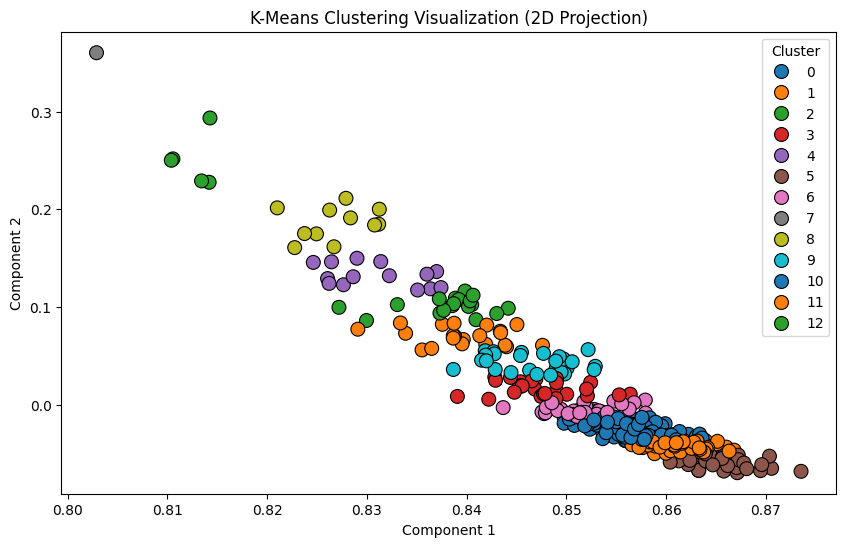

2025-03-09 16:27:07,557 : INFO : collecting all words and their counts
2025-03-09 16:27:07,559 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:07,561 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:07,568 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:07,572 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:07,576 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:07.576810', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:07,581 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:27:07 

Finished executing at: 2025-03-09 16:27:07 

Executed at: 2025-03-09 16:27:07 



2025-03-09 16:27:07,762 : INFO : EPOCH 0: training on 24723 raw words (4634 effective words) took 0.1s, 65654 effective words/s
2025-03-09 16:27:07,813 : INFO : EPOCH 1: training on 24723 raw words (4705 effective words) took 0.0s, 116838 effective words/s
2025-03-09 16:27:07,866 : INFO : EPOCH 2: training on 24723 raw words (4640 effective words) took 0.0s, 120611 effective words/s
2025-03-09 16:27:07,915 : INFO : EPOCH 3: training on 24723 raw words (4697 effective words) took 0.0s, 130330 effective words/s
2025-03-09 16:27:07,988 : INFO : EPOCH 4: training on 24723 raw words (4705 effective words) took 0.1s, 75867 effective words/s
2025-03-09 16:27:08,064 : INFO : EPOCH 5: training on 24723 raw words (4826 effective words) took 0.1s, 76333 effective words/s
2025-03-09 16:27:08,131 : INFO : EPOCH 6: training on 24723 raw words (4718 effective words) took 0.1s, 93778 effective words/s
2025-03-09 16:27:08,193 : INFO : EPOCH 7: training on 24723 raw words (4649 effective words) took 0.0

sg=1, Vector_Size=400, Window=5, Epoch=50
Finished displaying at: 2025-03-09 16:27:10 

Executing 13 start time: 2025-03-09 16:27:10
K=13: Silhouette Score and WSS=0.0832	1.2282

Cluster 0:
- In a first, new SC judges to take oath outdoors
- Ahmer honored for contributions to squash at K2 Squash Gold Event
- Jeffrey Sachs: Trump's tariff policy bound to fail
- JUI-F chief stands with journalists against PECA law
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC

Cluster 1:
- IK urges army chief to revisit policies in ‘best national interest’
- I want to become a UFC World Champion, Bano Butt on her dreams and breaking barriers
- Kinnaird College, PMAA equip young women with self-defense skills
- Justin Bieber’s comment on Keke Palmer’s post raises eyebrows amid Hailey Bieber divorce rumors
- Sri Lanka shares end higher; central bank sees inflation peak above target in Q2 next year

Cluster 2:
- Pakistan’s 2nd polio case of 2025 reported in Badin
- Champions Trophy 2025: s

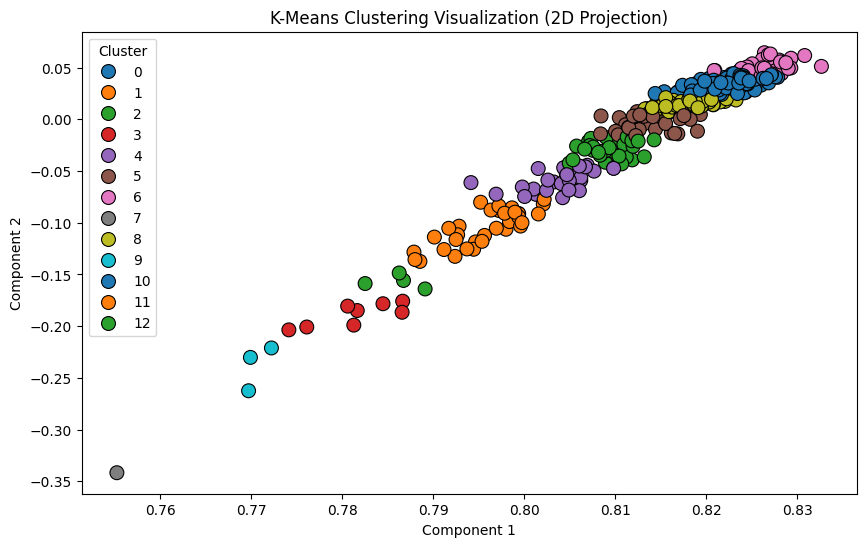

2025-03-09 16:27:12,456 : INFO : collecting all words and their counts
2025-03-09 16:27:12,466 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:12,483 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:12,509 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:12,520 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:12,534 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:12.534392', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:12,551 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:27:12 

Finished executing at: 2025-03-09 16:27:12 

Executed at: 2025-03-09 16:27:12 



2025-03-09 16:27:12,846 : INFO : EPOCH 0: training on 24723 raw words (4644 effective words) took 0.1s, 34007 effective words/s
2025-03-09 16:27:12,972 : INFO : EPOCH 1: training on 24723 raw words (4752 effective words) took 0.1s, 45537 effective words/s
2025-03-09 16:27:13,047 : INFO : EPOCH 2: training on 24723 raw words (4676 effective words) took 0.1s, 73111 effective words/s
2025-03-09 16:27:13,129 : INFO : EPOCH 3: training on 24723 raw words (4690 effective words) took 0.1s, 67418 effective words/s
2025-03-09 16:27:13,199 : INFO : EPOCH 4: training on 24723 raw words (4760 effective words) took 0.1s, 81559 effective words/s
2025-03-09 16:27:13,274 : INFO : EPOCH 5: training on 24723 raw words (4626 effective words) took 0.1s, 82222 effective words/s
2025-03-09 16:27:13,343 : INFO : EPOCH 6: training on 24723 raw words (4619 effective words) took 0.1s, 79402 effective words/s
2025-03-09 16:27:13,418 : INFO : EPOCH 7: training on 24723 raw words (4691 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=7, Epoch=50
Finished displaying at: 2025-03-09 16:27:16 

Executing 13 start time: 2025-03-09 16:27:16
K=13: Silhouette Score and WSS=0.0928	1.0235

Cluster 0:
- Karachi basketball at crossroads as rival factions clash
- Kuwait hosts high-level forum to discuss International Islamic Court of Justice
- The rise of a larger but weaker judiciary?
- Pakistan defeat South Africa in record chase
- 'No fear of references if innocent,' says Justice Mansoor Ali Shah

Cluster 1:
- This Valentine's Day, say yes to socks and no to flowers
- In a first, new SC judges to take oath outdoors
- Workshop stresses for shaping equitable, sustainable food systems
- South Green book berth in Rangers Cup Basketball final
- From Napa to Rada: Actor Hani Taha’s journey to the world’s premier drama school

Cluster 2:
- Page World Economy and Politics News Page 5
- Page World Economy and Politics News ISB Page 5
- Exploring love through the rhythm and blues of K-pop
- Local bodies m

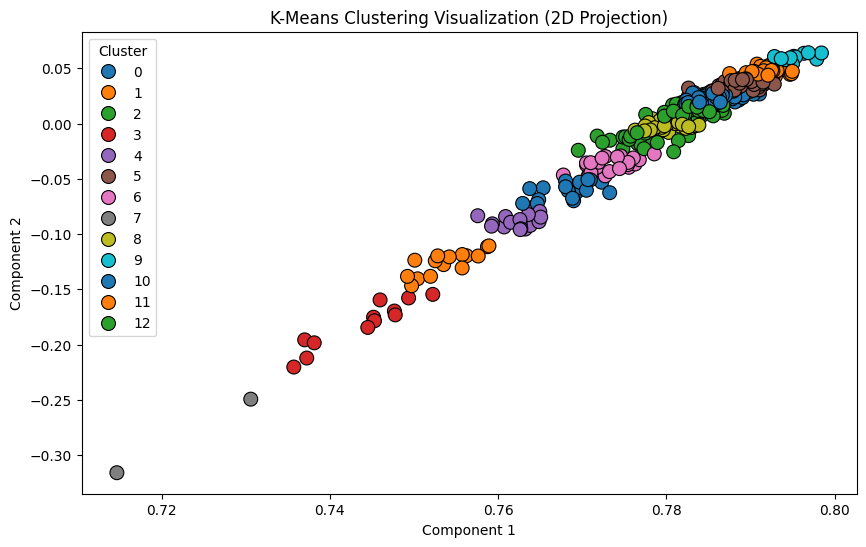

2025-03-09 16:27:19,025 : INFO : collecting all words and their counts
2025-03-09 16:27:19,027 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:19,029 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:19,041 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:19,044 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:19,047 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:19.047437', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:19,049 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:27:19 

Finished executing at: 2025-03-09 16:27:19 

Executed at: 2025-03-09 16:27:19 



2025-03-09 16:27:19,211 : INFO : EPOCH 0: training on 24723 raw words (4649 effective words) took 0.1s, 41032 effective words/s
2025-03-09 16:27:19,325 : INFO : EPOCH 1: training on 24723 raw words (4657 effective words) took 0.1s, 50542 effective words/s
2025-03-09 16:27:19,428 : INFO : EPOCH 2: training on 24723 raw words (4684 effective words) took 0.1s, 52329 effective words/s
2025-03-09 16:27:19,523 : INFO : EPOCH 3: training on 24723 raw words (4693 effective words) took 0.1s, 60081 effective words/s
2025-03-09 16:27:19,596 : INFO : EPOCH 4: training on 24723 raw words (4610 effective words) took 0.1s, 72500 effective words/s
2025-03-09 16:27:19,664 : INFO : EPOCH 5: training on 24723 raw words (4654 effective words) took 0.1s, 89470 effective words/s
2025-03-09 16:27:19,737 : INFO : EPOCH 6: training on 24723 raw words (4591 effective words) took 0.1s, 78550 effective words/s
2025-03-09 16:27:19,815 : INFO : EPOCH 7: training on 24723 raw words (4781 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=10, Epoch=50
Finished displaying at: 2025-03-09 16:27:23 

Executing 13 start time: 2025-03-09 16:27:23
K=13: Silhouette Score and WSS=0.0805	1.0311

Cluster 0:
- Law ministry notifies appointments of six SC judges, four high court chief justices
- In a first, new SC judges to take oath outdoors
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- PTI backed military courts after APS attack, says Justice Hilali
- Kuwait hosts high-level forum to discuss International Islamic Court of Justice

Cluster 1:
- PSG president Nasser Al-Khelaïfi indicted in Lagardère investigation
- Pakistan expresses strong concerns over US transfer of advanced technology to India
- Turkish President Erdogan receives guard of honour at PM House
- Six newly appointed Supreme Court judges take oath
- Caught in crossfire? Women under siege in influencer culture

Cluster 2:
- Pakistan’s 2nd polio case of 2025 reported in Badin
- Israeli military killed 85 journalists i

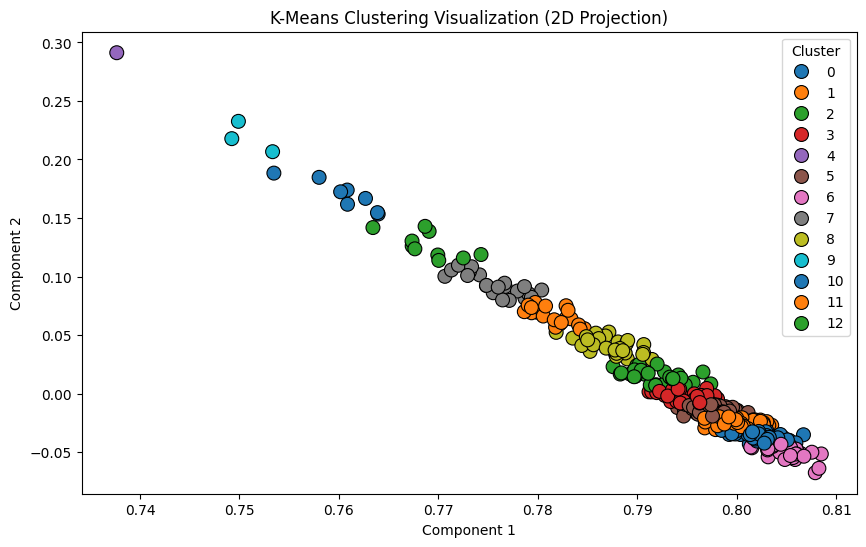

2025-03-09 16:27:24,362 : INFO : collecting all words and their counts
2025-03-09 16:27:24,364 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:24,366 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:24,375 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:24,377 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:24,381 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:24.381763', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:24,383 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:27:24 

Finished executing at: 2025-03-09 16:27:24 

Executed at: 2025-03-09 16:27:24 



2025-03-09 16:27:24,566 : INFO : EPOCH 1: training on 24723 raw words (4578 effective words) took 0.1s, 68512 effective words/s
2025-03-09 16:27:24,643 : INFO : EPOCH 2: training on 24723 raw words (4688 effective words) took 0.1s, 72070 effective words/s
2025-03-09 16:27:24,710 : INFO : EPOCH 3: training on 24723 raw words (4724 effective words) took 0.1s, 82049 effective words/s
2025-03-09 16:27:24,787 : INFO : EPOCH 4: training on 24723 raw words (4701 effective words) took 0.1s, 79282 effective words/s
2025-03-09 16:27:24,865 : INFO : EPOCH 5: training on 24723 raw words (4733 effective words) took 0.1s, 70077 effective words/s
2025-03-09 16:27:24,968 : INFO : EPOCH 6: training on 24723 raw words (4681 effective words) took 0.1s, 51483 effective words/s
2025-03-09 16:27:25,077 : INFO : EPOCH 7: training on 24723 raw words (4719 effective words) took 0.1s, 49477 effective words/s
2025-03-09 16:27:25,170 : INFO : EPOCH 8: training on 24723 raw words (4746 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=12, Epoch=50
Finished displaying at: 2025-03-09 16:27:29 

Executing 13 start time: 2025-03-09 16:27:29
K=13: Silhouette Score and WSS=0.0916	0.9675

Cluster 0:
- JUI-F chief stands with journalists against PECA law
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- Haveli of Maharaja Ranjit Singh being conserved by WCLA
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- Everyone can’t go to jail to meet Imran: IHC CJ

Cluster 1:
- IGP pays tributes to police martyrs of Faisal Chowk Mall Road tragedy
- South African rand firms after Trump’s tariff move; local budget next week
- PlayStation state of play returns with new games, trailers, and updates
- Russian drone attack damages Chernobyl shelter, Zelensky says
- US Attorney General Pam Bondi files lawsuit against New York's immigration law

Cluster 2:
- Cold and dry weather to prevail across Pakistan: PMD
- Page World Economy and Politics News ISB Page 5
- Ranked: The Best 

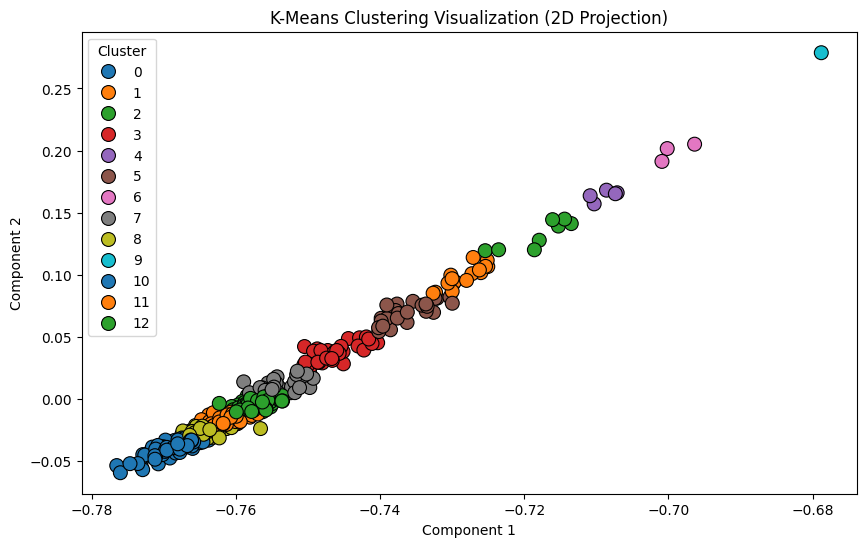

2025-03-09 16:27:30,137 : INFO : collecting all words and their counts
2025-03-09 16:27:30,141 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:30,143 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:30,156 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:30,159 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:30,162 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:30.162149', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:30,164 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:27:30 

Finished executing at: 2025-03-09 16:27:30 

Executed at: 2025-03-09 16:27:30 



2025-03-09 16:27:30,387 : INFO : EPOCH 1: training on 24723 raw words (4713 effective words) took 0.1s, 57125 effective words/s
2025-03-09 16:27:30,464 : INFO : EPOCH 2: training on 24723 raw words (4658 effective words) took 0.1s, 70720 effective words/s
2025-03-09 16:27:30,550 : INFO : EPOCH 3: training on 24723 raw words (4717 effective words) took 0.1s, 65486 effective words/s
2025-03-09 16:27:30,647 : INFO : EPOCH 4: training on 24723 raw words (4659 effective words) took 0.1s, 53943 effective words/s
2025-03-09 16:27:30,736 : INFO : EPOCH 5: training on 24723 raw words (4687 effective words) took 0.1s, 59885 effective words/s
2025-03-09 16:27:30,818 : INFO : EPOCH 6: training on 24723 raw words (4615 effective words) took 0.1s, 64752 effective words/s
2025-03-09 16:27:30,900 : INFO : EPOCH 7: training on 24723 raw words (4627 effective words) took 0.1s, 64681 effective words/s
2025-03-09 16:27:30,982 : INFO : EPOCH 8: training on 24723 raw words (4668 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=15, Epoch=50
Finished displaying at: 2025-03-09 16:27:34 

Executing 13 start time: 2025-03-09 16:27:34
K=13: Silhouette Score and WSS=0.0942	0.9246

Cluster 0:
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- Haveli of Maharaja Ranjit Singh being conserved by WCLA
- Law ministry notifies appointments of six SC judges, four high court chief justices
- Justice Mansoor Ali Shah dismisses reference fears, highlights judiciary’s performance

Cluster 1:
- CM Maryam announces 3-marla plots for homeless people
- Page World Economy and Politics News ISB Page 5
- Facebook demands confirmation from page operators on content for children under 13
- Salaried class tax payments surge to Rs285bn in seven months, minister hints at relief
- ICC announces prize money breakdown for Champions Trophy

Cluster 2:
- Trump says US has approved extradition of suspect in 2008 Mumbai attacks
- Umair 

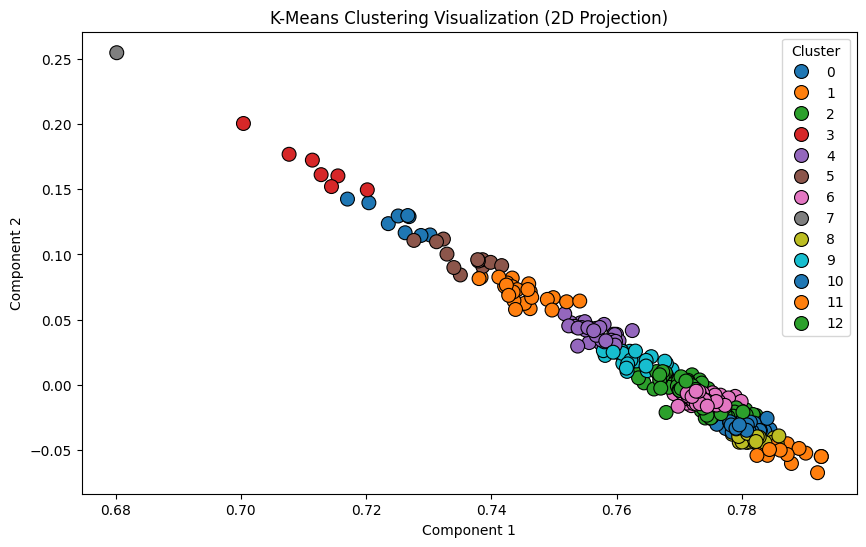

2025-03-09 16:27:35,816 : INFO : collecting all words and their counts
2025-03-09 16:27:35,818 : WARNING : Each 'sentences' item should be a list of words (usually unicode strings). First item here is instead plain <class 'str'>.
2025-03-09 16:27:35,822 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2025-03-09 16:27:35,836 : INFO : collected 38 word types from a corpus of 24723 raw words and 453 sentences
2025-03-09 16:27:35,839 : INFO : Creating a fresh vocabulary
2025-03-09 16:27:35,842 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 38 unique words (100.00% of original 38, drops 0)', 'datetime': '2025-03-09T16:27:35.842887', 'gensim': '4.3.3', 'python': '3.12.9 (tags/v3.12.9:fdb8142, Feb  4 2025, 15:27:58) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
2025-03-09 16:27:35,844 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 24723 word corpus (100.00% of origi

Finished displaying at: 2025-03-09 16:27:35 

Finished executing at: 2025-03-09 16:27:35 

Executed at: 2025-03-09 16:27:35 



2025-03-09 16:27:36,095 : INFO : EPOCH 1: training on 24723 raw words (4673 effective words) took 0.1s, 51748 effective words/s
2025-03-09 16:27:36,294 : INFO : EPOCH 2: training on 24723 raw words (4673 effective words) took 0.2s, 24717 effective words/s
2025-03-09 16:27:36,454 : INFO : EPOCH 3: training on 24723 raw words (4616 effective words) took 0.1s, 37022 effective words/s
2025-03-09 16:27:36,561 : INFO : EPOCH 4: training on 24723 raw words (4661 effective words) took 0.1s, 51107 effective words/s
2025-03-09 16:27:36,661 : INFO : EPOCH 5: training on 24723 raw words (4642 effective words) took 0.1s, 52242 effective words/s
2025-03-09 16:27:36,791 : INFO : EPOCH 6: training on 24723 raw words (4695 effective words) took 0.1s, 41287 effective words/s
2025-03-09 16:27:36,903 : INFO : EPOCH 7: training on 24723 raw words (4676 effective words) took 0.1s, 46944 effective words/s
2025-03-09 16:27:37,008 : INFO : EPOCH 8: training on 24723 raw words (4630 effective words) took 0.1s, 

sg=1, Vector_Size=400, Window=20, Epoch=50
Finished displaying at: 2025-03-09 16:27:41 

Executing 13 start time: 2025-03-09 16:27:41
K=13: Silhouette Score and WSS=0.0926	0.9668

Cluster 0:
- JUI-F chief stands with journalists against PECA law
- Justice Sarfraz Dogar sworn in as acting chief justice of IHC
- Haveli of Maharaja Ranjit Singh being conserved by WCLA
- Justice Sarfraz Dogar takes oath as acting Chief Justice of IHC
- Everyone can’t go to jail to meet Imran: IHC CJ

Cluster 1:
- Pakistan set 243-run target for New Zealand in Tri-Nation series final
- Tri-series final: Pakistan set 243-run target for New Zealand
- Power of AI brings Urdu books to life
- Ahmer honored for contributions to squash at K2 Squash Gold Event
- If love hurts, the Sufis say you’re doing it right

Cluster 2:
- Over 16,000 School Teacher Jobs 2025 – Here’s all you need to know
- Solar panel imports: 80 companies transferred around Rs106bn abroad: FBR
- Stocks remain range-bound, KSE-100 closes 361 po

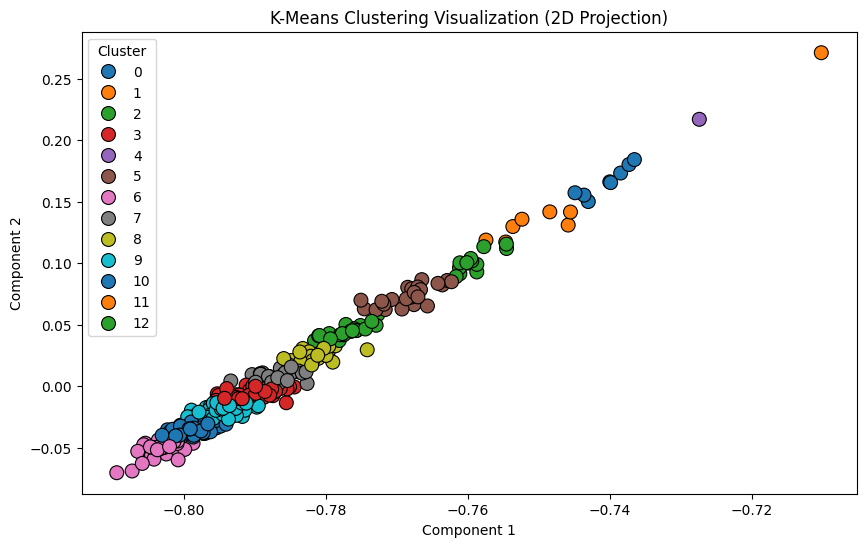

Finished displaying at: 2025-03-09 16:27:42 

Finished executing at: 2025-03-09 16:27:42 



In [925]:
best_combination, best_Sil, best_WSS = run_combinations(13, best_combination, best_Sil, best_WSS)

In [926]:
# Convert to DataFrame for easy export
results_df = pd.DataFrame(results, columns=['k', 'Vectorizer Type', 'vector_size', 'window', 'Epochs Count', 'Vectorizer Name', 'Silhouette Score', 'WSS Score'])

# Save results
results_df.to_csv("clustering_results.csv", index=False)

# Open the file automatically
os.startfile("clustering_results.csv")

results_df

,k,Vectorizer Type,vector_size,window,Epochs Count,Vectorizer Name,Silhouette Score,WSS Score
0,5,Word2Vec,400,3,50,Skipgram,0.108400,2.163487
1,5,Word2Vec,400,5,50,Skipgram,0.111734,1.653470
2,5,Word2Vec,400,7,50,Skipgram,0.153372,1.412583
3,5,Word2Vec,400,10,50,Skipgram,0.098823,1.308554
4,5,Word2Vec,400,12,50,Skipgram,0.127235,1.224069
5,5,Word2Vec,400,15,50,Skipgram,0.100612,1.196420
6,5,Word2Vec,400,20,50,Skipgram,0.110147,1.162747
7,9,Word2Vec,400,3,50,Skipgram,0.097876,1.685105
8,9,Word2Vec,400,5,50,Skipgram,0.103571,1.309791
9,9,Word2Vec,400,7,50,Skipgram,0.101574,1.222073


In [927]:
# Convert to DataFrame for easy export
wss_scores_df = pd.DataFrame(wss_scores, columns=['k', 'Average WSS Score'])

wss_scores_df

,k,Average WSS Score
0,5,1.445904
1,9,1.195006
2,13,1.091909


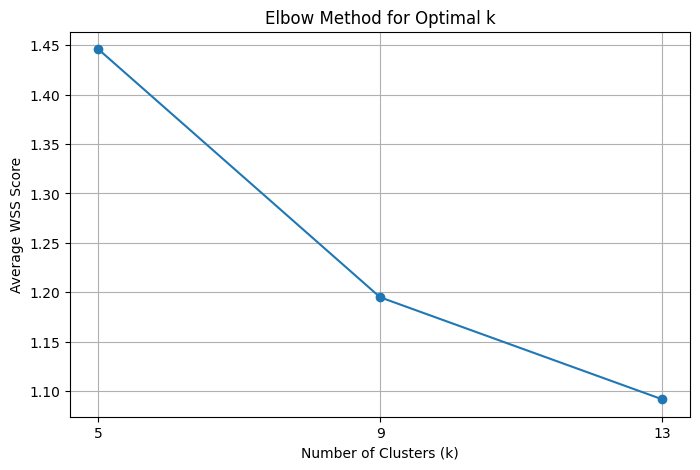

In [928]:
# Plot the elbow plot
plt.figure(figsize=(8, 5))
plt.plot(wss_scores_df['k'], wss_scores_df['Average WSS Score'], marker='o', linestyle='-')

# Add labels and title
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average WSS Score")
plt.title("Elbow Method for Optimal k")
plt.xticks(wss_scores_df['k'])  # Ensure all k values are shown on x-axis
plt.grid(True)

# Show the plot
plt.show()

In [929]:
best_combination # vector size, window size, epoch

[13, 'word', 'Skipgram', 400, 15, 50, 0.094204195, 0.9246314167976379]